In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

In [2]:
data = pd.read_csv('train.csv')

In [3]:
with open('data_description.txt') as f:
    print(f.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [4]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
data.drop(['Id'], axis=1, inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

In [7]:
y = data.SalePrice
X = data.drop('SalePrice', axis=1)

In [10]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

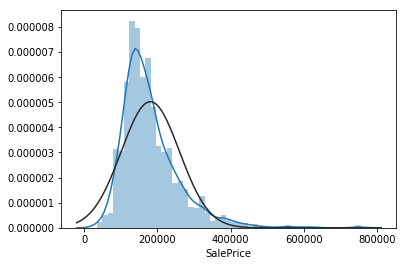

In [18]:
sns.distplot(y, fit=stats.norm)


# Features Engineering

In [19]:
from sklearn.preprocessing import LabelEncoder

def clean_data(data):
    obj_features = list(data.dtypes[data.dtypes=='object'].index)
    data[obj_features] = data[obj_features].fillna('na')
    data['LotFrontage'].fillna(0, inplace=True)
    data['MasVnrArea'].fillna(0, inplace=True)
    #Дата постройки гаража, скорее всего, коррелирует с датой постройки дома. Можно убрать.
    #Площадь гаража и количество автомобилей в гараже должны коррелировать. Можно убрать количество авто.
    #Параметр Condition2 можно убрать, так как он отличается только у 15 объектов.
    data.drop(['GarageYrBlt','GarageCars','Condition2'], axis=1, inplace=True)
    #Параметр 'YearRemodAdd' переведен в бинарный формат, так как имеет смысл, только если отличен от года постройки
    data['YearRemodAdd'] = data.apply(lambda x: 0 if x['YearBuilt']==x['YearRemodAdd'] else 1, axis=1)
    #Следующие параметры, скорее, категориальные, поэтому есть смысл их преобразовать
    data['MSSubClass'] = data['MSSubClass'].astype(str)
    #Эти параметры имеют только по 2 категории, поэтому можно преобразовать в бинарный:
    data['Street'] = data['Street'].apply(lambda x: 0 if x=='Grvl' else 1)
    data['CentralAir'] = data['CentralAir'].apply(lambda x: 0 if x=='N' else 1)
    #Некоторые объектные параметры можно закодировать числами, так как порядок имеет значение:
    for c in ['Alley','LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
             'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 
             'GarageCond', 'PavedDrive', 'PoolQC']:
        le = LabelEncoder()
        le.fit(data[c])
        data[c] = le.transform(data[c])
    #так как некоторые параметры преобразованы, необходимо обновить список объектных:
    obj_features = list(data.dtypes[data.dtypes=='object'].index)
    return pd.get_dummies(data, columns=obj_features)
    

In [20]:
X = clean_data(X)

In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 238 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(2), int64(51), uint8(185)
memory usage: 868.4 KB


# Построение модели

**Random Forest с CrossValidation**

In [164]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

trees = RandomForestRegressor(n_estimators=10, max_leaf_nodes=30)
scaler = StandardScaler()

X_Scaled = scaler.fit_transform(X)

/data/user/0/ru.iiec.pydroid3/files/aarch64-linux-android/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/data/user/0/ru.iiec.pydroid3/files/aarch64-linux-android/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [170]:
cv = cross_validate(trees, X_Scaled, y, cv=10, scoring='neg_mean_absolute_error', return_estimator=True, return_train_score=True)

print('Train mae:      {0:.2f}'.format(-np.mean(cv.get('train_score'))))
print('Test mae:       {0:.2f}'.format(-np.mean(cv.get('test_score'))))
print('StdDev of test: {0:.2f}'.format(np.std(cv.get('test_score'))))


Train mae:      17215.63
Test mae:       21714.34
StdDev of test: 2209.47


Модель чрезмерно обучена, даже после того, как было ограничено количество leaf nodes.

In [168]:
nams = pd.DataFrame(X.columns, columns=['Features'])
for i, val in zip(range(10),cv.get('estimator')):
    vals = pd.DataFrame(val.feature_importances_, columns=['Importances_'+str(i)])
    nams = pd.concat((nams,vals), axis=1)


In [172]:
nams.sort_values(by='Importances_0', ascending=False)[:10]

,Features,Importances_0,Importances_1,Importances_2,Importances_3,Importances_4,Importances_5,Importances_6,Importances_7,Importances_8,Importances_9
6,OverallQual,0.640320,0.631050,0.625543,0.670611,0.669019,0.633998,0.633820,0.668213,0.647602,0.620774
27,GrLivArea,0.112283,0.111878,0.122523,0.092483,0.126794,0.102980,0.132314,0.121772,0.123961,0.091514
21,TotalBsmtSF,0.044304,0.034784,0.042048,0.028861,0.046065,0.048127,0.038540,0.031810,0.052060,0.042242
25,2ndFlrSF,0.037822,0.043942,0.019637,0.044626,0.022659,0.040468,0.053963,0.019525,0.004468,0.065065
24,1stFlrSF,0.026919,0.004451,0.016618,0.017330,0.009881,0.012890,0.014183,0.025633,0.008792,0.013320
17,BsmtFinSF1,0.020446,0.037591,0.025063,0.018990,0.013462,0.037238,0.025082,0.029141,0.036136,0.027201
1,LotArea,0.013828,0.005277,0.023105,0.005759,0.002809,0.006871,0.019062,0.005378,0.006956,0.012470
13,BsmtQual,0.013717,0.012613,0.000878,0.003266,0.001158,0.000591,0.004012,0.001880,0.000688,0.035349
39,GarageArea,0.010579,0.021244,0.022683,0.027136,0.028360,0.020510,0.012031,0.026789,0.024087,0.012360
8,YearBuilt,0.009249,0.006827,0.004587,0.011556,0.009005,0.002976,0.009314,0.014583,0.006579,0.009277


Закономерно, наибольшее влияние на цену оказывают размер жилой площади, а так же общее состояние и качество материалов постройки. Год постройки даже не вошел в 10ку самых существенных признаков.

**Stacking**

In [331]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True)


In [332]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

lr = LinearRegression()
dt = DecisionTreeRegressor(max_depth=3)
rf = RandomForestRegressor(n_estimators=10)

models = [lr, dt, rf]


In [348]:
predictions = []

for model in models:
    meta = np.empty_like(y)
    for train, held_out in kfold.split(X):
        model.fit(np.array(X)[train], np.array(y)[train])
        meta[held_out] = model.predict(np.array(X)[held_out])
    predictions.append(meta)


In [349]:
predictions = np.stack(predictions, axis=1)

In [351]:
blender = LinearRegression()
cv = cross_validate(blender, predictions, y, cv=10, scoring='neg_mean_absolute_error', return_estimator=True, return_train_score=True)
print('Train mae:      {0:.2f}'.format(-np.mean(cv.get('train_score'))))
print('Test mae:       {0:.2f}'.format(-np.mean(cv.get('test_score'))))
print('StdDev of test: {0:.2f}'.format(np.std(cv.get('test_score'))))


Train mae:      19464.38
Test mae:       19566.97
StdDev of test: 1952.45


Результат для тестовой выборки видимо улучшился - кроме того, что оценка стала лучше, на обучающей и тестовой выборках они совпадают, что говорит о хорошем обобщении.